##Business Problem
A Brain tumor is considered as one of the aggressive diseases, among children and adults. Brain tumors account for 85 to 90 percent of all primary Central Nervous System(CNS) tumors. Every year, around 11,700 people are diagnosed with a brain tumor. The best technique to detect brain tumors is Magnetic Resonance Imaging (MRI). A huge amount of image data is generated through the scans. These images are examined by the radiologist, which is a manual process.

Our primary objective is to develop an accurate and efficient deep learning algorithm that can analyze medical images and rapidly predict the presence of tumors. By leveraging the power of convolutional neural networks (CNNs), our approach aims to automate and expedite the detection process, leading to faster diagnoses and improved patient outcomes.


In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
#loading data
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

 86% 75.0M/86.8M [00:00<00:00, 134MB/s]
100% 86.8M/86.8M [00:00<00:00, 95.4MB/s]


In [3]:
#unziping files
import zipfile
with zipfile.ZipFile('brain-tumor-classification-mri.zip') as mri:
  mri.extractall()

In [4]:
#impoorting libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from skimage import io
import seaborn as sns
from keras.utils import plot_model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.applications import VGG16

In [5]:
#train, test, classes
train = '/content/Training/'
test = '/content/Testing/'
classes = ['glioma_tumor','meningioma_tumor', 'no_tumor', 'pituitary_tumor']

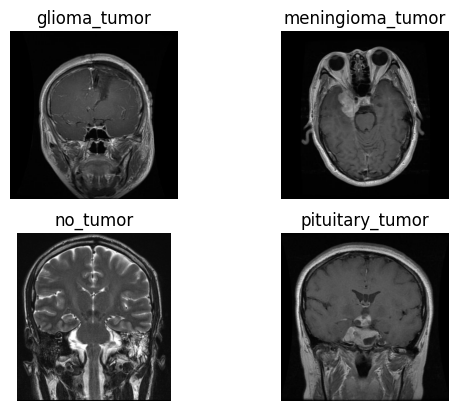

In [6]:
#plotting images of different classes
for i,j in enumerate(classes):
  plt.subplot(2,2,i+1)
  disease_path = os.path.join(train, classes[i],'*')
  disease = glob.glob(disease_path)
  image = io.imread(disease[0])
  plt.axis('off')
  plt.title(j)
  plt.imshow(image)

In [7]:
#count of different classes
for i in classes:
  path = os.path.join(train, i, '*')
  count = len(glob.glob(path))
  print(i, '-', count)

glioma_tumor - 826
meningioma_tumor - 822
no_tumor - 395
pituitary_tumor - 827


In [8]:
#data augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    vertical_flip=True,
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [9]:
#flow from directory
train_generator = train_datagen.flow_from_directory(
    directory = '/content/Training',
    batch_size = 35,
    class_mode = 'categorical',
    shuffle = True,
    color_mode = 'rgb',
    target_size = (252,252)
)

test_generator = test_datagen.flow_from_directory(
    directory = '/content/Testing',
    batch_size = 197,
    class_mode = 'categorical',
    shuffle=False,
    color_mode = 'rgb',
    target_size = (252,252)
)

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


#### ResNet Model

In [ ]:
#base model
base_model_res = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(252,252,3)
)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
#summary
base_model_res.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 252, 252, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 258, 258, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 126, 126, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
#layer names
for layer in base_model_res.layers:
  print(layer.name)

input_1
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [ ]:
# making layers trainable
base_model_res.trainable = True
set_trainable = False
for layer in base_model_res.layers:
  if 'conv5_block3' in layer.name:
    set_trainable = True
  if set_trainable:
    layer.trainable=True
  else:
    layer.trainable = False

for layer in base_model_res.layers:
  print(layer.name,'-', layer.trainable)

input_1 - False
conv1_pad - False
conv1_conv - False
conv1_bn - False
conv1_relu - False
pool1_pad - False
pool1_pool - False
conv2_block1_1_conv - False
conv2_block1_1_bn - False
conv2_block1_1_relu - False
conv2_block1_2_conv - False
conv2_block1_2_bn - False
conv2_block1_2_relu - False
conv2_block1_0_conv - False
conv2_block1_3_conv - False
conv2_block1_0_bn - False
conv2_block1_3_bn - False
conv2_block1_add - False
conv2_block1_out - False
conv2_block2_1_conv - False
conv2_block2_1_bn - False
conv2_block2_1_relu - False
conv2_block2_2_conv - False
conv2_block2_2_bn - False
conv2_block2_2_relu - False
conv2_block2_3_conv - False
conv2_block2_3_bn - False
conv2_block2_add - False
conv2_block2_out - False
conv2_block3_1_conv - False
conv2_block3_1_bn - False
conv2_block3_1_relu - False
conv2_block3_2_conv - False
conv2_block3_2_bn - False
conv2_block3_2_relu - False
conv2_block3_3_conv - False
conv2_block3_3_bn - False
conv2_block3_add - False
conv2_block3_out - False
conv3_block1_1_c

In [ ]:
#model building
model_1 = Sequential()
model_1.add(base_model_res)
model_1.add(Flatten())
model_1.add(Dense(256, activation='relu'))
model_1.add(Dense(4,activation='softmax'))

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 256)               33554688  
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 57,143,428
Trainable params: 38,021,380
Non-trainable params: 19,122,048
_________________________________________________________________


In [ ]:
#compile
model_1.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), loss = 'categorical_crossentropy', metrics= [tf.keras.metrics.Recall()])

In [ ]:
#fit
history_res = model_1.fit(train_generator, validation_data=test_generator, epochs=50)

Epoch 1/50
82/82 [==============================] - 40s 305ms/step - loss: 1.7215 - recall: 0.1666 - val_loss: 1.6854 - val_recall: 0.1117
Epoch 2/50
82/82 [==============================] - 15s 186ms/step - loss: 1.0140 - recall: 0.3965 - val_loss: 1.7337 - val_recall: 0.1117
Epoch 3/50
82/82 [==============================] - 15s 186ms/step - loss: 0.8873 - recall: 0.5136 - val_loss: 2.0121 - val_recall: 0.2817
Epoch 4/50
82/82 [==============================] - 16s 195ms/step - loss: 0.8213 - recall: 0.5638 - val_loss: 2.0089 - val_recall: 0.2868
Epoch 5/50
82/82 [==============================] - 16s 198ms/step - loss: 0.7759 - recall: 0.5916 - val_loss: 2.2051 - val_recall: 0.3401
Epoch 6/50
82/82 [==============================] - 16s 195ms/step - loss: 0.7483 - recall: 0.6136 - val_loss: 2.1838 - val_recall: 0.3173
Epoch 7/50
82/82 [==============================] - 16s 195ms/step - loss: 0.6976 - recall: 0.6460 - val_loss: 2.6033 - val_recall: 0.2944
Epoch 8/50
82/82 [=========

In [ ]:
#model building
model_2 = Sequential()
model_2.add(base_model_res)
model_2.add(Flatten())
model_2.add(Dense(256, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.5))
model_2.add(Dense(4,activation='softmax'))

In [ ]:
#compile
model_2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), loss = 'categorical_crossentropy', metrics= [tf.keras.metrics.Recall()])

In [ ]:
#fit
history = model_2.fit(train_generator, validation_data=test_generator, epochs=50)

Epoch 1/50
82/82 [==============================] - 23s 224ms/step - loss: 0.9830 - recall_1: 0.6056 - val_loss: 5.4094 - val_recall_1: 0.3680
Epoch 2/50
82/82 [==============================] - 16s 198ms/step - loss: 0.7473 - recall_1: 0.6927 - val_loss: 3.6807 - val_recall_1: 0.3883
Epoch 3/50
82/82 [==============================] - 16s 193ms/step - loss: 0.6373 - recall_1: 0.7314 - val_loss: 2.4159 - val_recall_1: 0.3883
Epoch 4/50
82/82 [==============================] - 16s 191ms/step - loss: 0.5762 - recall_1: 0.7693 - val_loss: 2.6982 - val_recall_1: 0.4569
Epoch 5/50
82/82 [==============================] - 16s 194ms/step - loss: 0.5404 - recall_1: 0.7711 - val_loss: 3.5325 - val_recall_1: 0.3655
Epoch 6/50
82/82 [==============================] - 17s 203ms/step - loss: 0.5427 - recall_1: 0.7787 - val_loss: 2.2204 - val_recall_1: 0.4492
Epoch 7/50
82/82 [==============================] - 19s 236ms/step - loss: 0.4892 - recall_1: 0.7923 - val_loss: 4.4461 - val_recall_1: 0.3147

####VGG16 Model

In [10]:
#base vgg model
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(252,252,3)
)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
#printing layer name
for layer in base_model.layers:
  print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [ ]:
#making layers trainable
base_model.trainable = True
set_trainable = False
for layer in base_model.layers:
  if 'block5' in layer.name:
    set_trainable=True
  if set_trainable:
    layer.trainable=True
  else:
    layer.trainable = False

for layer in base_model.layers:
  print(layer.name, '-', layer.trainable)

input_2 - False
block1_conv1 - False
block1_conv2 - False
block1_pool - False
block2_conv1 - False
block2_conv2 - False
block2_pool - False
block3_conv1 - False
block3_conv2 - False
block3_conv3 - False
block3_pool - False
block4_conv1 - False
block4_conv2 - False
block4_conv3 - False
block4_pool - False
block5_conv1 - True
block5_conv2 - True
block5_conv3 - True
block5_pool - True


In [ ]:
#model building
model_vgg = Sequential()
model_vgg.add(base_model)
model_vgg.add(Flatten())
model_vgg.add(Dense(256, activation='relu'))
model_vgg.add(Dense(4,activation='softmax'))

In [ ]:
#compile
model_vgg.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5), loss = 'categorical_crossentropy', metrics = [tf.keras.metrics.Recall()])

In [ ]:
#fit
history_vgg = model_vgg.fit(train_generator, validation_data=test_generator, epochs=50)

Epoch 1/50
82/82 [==============================] - 67s 688ms/step - loss: 0.8141 - recall_2: 0.4955 - val_loss: 1.5372 - val_recall_2: 0.4239
Epoch 2/50
82/82 [==============================] - 25s 301ms/step - loss: 0.4717 - recall_2: 0.7857 - val_loss: 1.4317 - val_recall_2: 0.5457
Epoch 3/50
82/82 [==============================] - 25s 304ms/step - loss: 0.3561 - recall_2: 0.8484 - val_loss: 1.7230 - val_recall_2: 0.5939
Epoch 4/50
82/82 [==============================] - 24s 295ms/step - loss: 0.2939 - recall_2: 0.8767 - val_loss: 1.5515 - val_recall_2: 0.6624
Epoch 5/50
82/82 [==============================] - 25s 304ms/step - loss: 0.2485 - recall_2: 0.8997 - val_loss: 1.5937 - val_recall_2: 0.6650
Epoch 6/50
82/82 [==============================] - 24s 294ms/step - loss: 0.2031 - recall_2: 0.9223 - val_loss: 1.7636 - val_recall_2: 0.6853
Epoch 7/50
82/82 [==============================] - 24s 295ms/step - loss: 0.1714 - recall_2: 0.9408 - val_loss: 1.8378 - val_recall_2: 0.6878

In [ ]:
#model building
model_vgg2 = Sequential()
model_vgg2.add(base_model)
model_vgg2.add(Flatten())
model_vgg2.add(Dense(256, activation='relu'))
model_vgg2.add(BatchNormalization())
model_vgg2.add(Dropout(0.5))
model_vgg2.add(Dense(4,activation='softmax'))

In [ ]:
#compile
model_vgg2.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5), loss= 'categorical_crossentropy', metrics=[tf.keras.metrics.Recall()])

In [ ]:
#fit
history_vgg2 = model_vgg2.fit(train_generator, validation_data = test_generator, epochs=30)

Epoch 1/30
82/82 [==============================] - 34s 338ms/step - loss: 0.7930 - recall_3: 0.6857 - val_loss: 1.7091 - val_recall_3: 0.5381
Epoch 2/30
82/82 [==============================] - 25s 300ms/step - loss: 0.3638 - recall_3: 0.8498 - val_loss: 1.8514 - val_recall_3: 0.6345
Epoch 3/30
82/82 [==============================] - 24s 297ms/step - loss: 0.2298 - recall_3: 0.8983 - val_loss: 1.6989 - val_recall_3: 0.6624
Epoch 4/30
82/82 [==============================] - 25s 305ms/step - loss: 0.2132 - recall_3: 0.9150 - val_loss: 1.6182 - val_recall_3: 0.6853
Epoch 5/30
82/82 [==============================] - 24s 293ms/step - loss: 0.1578 - recall_3: 0.9401 - val_loss: 1.7121 - val_recall_3: 0.7208
Epoch 6/30
82/82 [==============================] - 26s 318ms/step - loss: 0.1346 - recall_3: 0.9488 - val_loss: 1.9800 - val_recall_3: 0.7208
Epoch 7/30
82/82 [==============================] - 25s 309ms/step - loss: 0.0995 - recall_3: 0.9613 - val_loss: 1.6226 - val_recall_3: 0.7411

In [ ]:
#model building
model_vgg3 = Sequential()
model_vgg3.add(base_model)
model_vgg3.add(Flatten())
model_vgg3.add(Dense(128, activation='relu'))
model_vgg3.add(BatchNormalization())
model_vgg3.add(Dropout(0.5))
model_vgg3.add(Dense(4,activation='softmax'))
#compile
model_vgg3.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5), loss= 'categorical_crossentropy', metrics=[tf.keras.metrics.Recall()])
#fit
history_vgg3 = model_vgg3.fit(train_generator, validation_data = test_generator, epochs=30)

Epoch 1/30
82/82 [==============================] - 29s 313ms/step - loss: 0.7340 - recall_4: 0.6951 - val_loss: 1.3304 - val_recall_4: 0.4695
Epoch 2/30
82/82 [==============================] - 24s 297ms/step - loss: 0.2803 - recall_4: 0.8847 - val_loss: 1.1810 - val_recall_4: 0.6701
Epoch 3/30
82/82 [==============================] - 24s 296ms/step - loss: 0.1946 - recall_4: 0.9220 - val_loss: 1.4299 - val_recall_4: 0.6904
Epoch 4/30
82/82 [==============================] - 26s 318ms/step - loss: 0.1339 - recall_4: 0.9533 - val_loss: 1.4299 - val_recall_4: 0.7081
Epoch 5/30
82/82 [==============================] - 25s 303ms/step - loss: 0.1004 - recall_4: 0.9652 - val_loss: 1.3576 - val_recall_4: 0.7234
Epoch 6/30
82/82 [==============================] - 24s 296ms/step - loss: 0.0779 - recall_4: 0.9700 - val_loss: 1.4025 - val_recall_4: 0.7259
Epoch 7/30
82/82 [==============================] - 24s 296ms/step - loss: 0.0615 - recall_4: 0.9787 - val_loss: 1.4810 - val_recall_4: 0.7487

In [ ]:
#model building
model_vgg4 = Sequential()
model_vgg4.add(base_model)
model_vgg4.add(Flatten())
model_vgg4.add(Dense(128, activation='relu'))
model_vgg4.add(BatchNormalization())
model_vgg4.add(Dropout(0.5))
model_vgg4.add(Dense(4,activation='softmax'))
#compile
model_vgg4.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5), loss= 'categorical_crossentropy', metrics=[tf.keras.metrics.Recall()])
#fit
history_vgg4 = model_vgg4.fit(train_generator, validation_data = test_generator, epochs=30)

Epoch 1/30
82/82 [==============================] - 29s 328ms/step - loss: 0.6318 - recall_5: 0.7220 - val_loss: 1.1882 - val_recall_5: 0.4949
Epoch 2/30
82/82 [==============================] - 24s 291ms/step - loss: 0.2120 - recall_5: 0.9136 - val_loss: 1.0684 - val_recall_5: 0.7056
Epoch 3/30
82/82 [==============================] - 25s 305ms/step - loss: 0.1209 - recall_5: 0.9585 - val_loss: 1.1796 - val_recall_5: 0.7513
Epoch 4/30
82/82 [==============================] - 24s 297ms/step - loss: 0.0774 - recall_5: 0.9777 - val_loss: 1.3207 - val_recall_5: 0.7513
Epoch 5/30
82/82 [==============================] - 24s 292ms/step - loss: 0.0653 - recall_5: 0.9770 - val_loss: 1.4207 - val_recall_5: 0.7589
Epoch 6/30
82/82 [==============================] - 24s 297ms/step - loss: 0.0445 - recall_5: 0.9864 - val_loss: 1.6835 - val_recall_5: 0.7234
Epoch 7/30
82/82 [==============================] - 24s 297ms/step - loss: 0.0356 - recall_5: 0.9920 - val_loss: 1.4576 - val_recall_5: 0.7868

In [ ]:
#saving model
model_vgg3.save('/content/drive/MyDrive/CNN_tumor/model_vgg3.h5')


In [11]:
#model building
model_vgg_reg = Sequential()
model_vgg_reg.add(base_model)
model_vgg_reg.add(Flatten())
model_vgg_reg.add(Dense(128, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)))
model_vgg_reg.add(BatchNormalization())
model_vgg_reg.add(Dropout(0.5))
model_vgg_reg.add(Dense(4,activation='softmax'))
#compile
model_vgg_reg.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5), loss= 'categorical_crossentropy', metrics=[tf.keras.metrics.Recall()])
#fit
model_vgg_reg = model_vgg_reg.fit(train_generator, validation_data = test_generator, epochs=30)

Epoch 1/30
82/82 [==============================] - 124s 1s/step - loss: 3.4935 - recall: 0.5840 - val_loss: 3.8508 - val_recall: 0.2893
Epoch 2/30
82/82 [==============================] - 56s 678ms/step - loss: 3.0068 - recall: 0.7711 - val_loss: 3.6957 - val_recall: 0.4645
Epoch 3/30
82/82 [==============================] - 57s 691ms/step - loss: 2.7874 - recall: 0.8233 - val_loss: 3.8232 - val_recall: 0.5584
Epoch 4/30
82/82 [==============================] - 56s 681ms/step - loss: 2.5831 - recall: 0.8575 - val_loss: 3.9218 - val_recall: 0.5736
Epoch 5/30
82/82 [==============================] - 57s 689ms/step - loss: 2.4366 - recall: 0.8969 - val_loss: 3.9741 - val_recall: 0.6066
Epoch 6/30
82/82 [==============================] - 57s 696ms/step - loss: 2.3095 - recall: 0.9153 - val_loss: 3.7551 - val_recall: 0.6878
Epoch 7/30
82/82 [==============================] - 56s 684ms/step - loss: 2.1935 - recall: 0.9220 - val_loss: 3.7181 - val_recall: 0.6726
Epoch 8/30
82/82 [===========

In [12]:
#model building
model_vgg_reg2 = Sequential()
model_vgg_reg2.add(base_model)
model_vgg_reg2.add(Flatten())
model_vgg_reg2.add(Dense(128, activation='relu', kernel_regularizer = tf.keras.regularizers.l1(0.01)))
model_vgg_reg2.add(BatchNormalization())
model_vgg_reg2.add(Dropout(0.5))
model_vgg_reg2.add(Dense(4,activation='softmax'))
#compile
model_vgg_reg2.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4), loss= 'categorical_crossentropy', metrics=[tf.keras.metrics.Recall()])
#fit
model_vgg_reg2 = model_vgg_reg2.fit(train_generator, validation_data = test_generator, epochs=30)

Epoch 1/30
82/82 [==============================] - 72s 695ms/step - loss: 142.5976 - recall_1: 0.5091 - val_loss: 81.6090 - val_recall_1: 0.2411
Epoch 2/30
82/82 [==============================] - 56s 681ms/step - loss: 28.2771 - recall_1: 0.7456 - val_loss: 13.8977 - val_recall_1: 0.2462
Epoch 3/30
82/82 [==============================] - 56s 683ms/step - loss: 5.4425 - recall_1: 0.8188 - val_loss: 5.5543 - val_recall_1: 0.5482
Epoch 4/30
82/82 [==============================] - 57s 691ms/step - loss: 3.1766 - recall_1: 0.8652 - val_loss: 4.8270 - val_recall_1: 0.5990
Epoch 5/30
82/82 [==============================] - 56s 677ms/step - loss: 2.5833 - recall_1: 0.8801 - val_loss: 6.4399 - val_recall_1: 0.4492
Epoch 6/30
82/82 [==============================] - 57s 693ms/step - loss: 2.3604 - recall_1: 0.8913 - val_loss: 4.2067 - val_recall_1: 0.6066
Epoch 7/30
82/82 [==============================] - 56s 684ms/step - loss: 2.1876 - recall_1: 0.9052 - val_loss: 7.3258 - val_recall_1: 0

In [13]:
#model building
model_vgg_reg3 = Sequential()
model_vgg_reg3.add(base_model)
model_vgg_reg3.add(Flatten())
model_vgg_reg3.add(Dense(128, activation='relu'))
model_vgg_reg3.add(BatchNormalization())
model_vgg_reg3.add(Dropout(0.75))
model_vgg_reg3.add(Dense(4,activation='softmax'))
#compile
model_vgg_reg3.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5), loss= 'categorical_crossentropy', metrics=[tf.keras.metrics.Recall()])
#fit
model_vgg_reg3 = model_vgg_reg3.fit(train_generator, validation_data = test_generator, epochs=30)

Epoch 1/30
82/82 [==============================] - 73s 746ms/step - loss: 1.7632 - recall_2: 0.3808 - val_loss: 3.4814 - val_recall_2: 0.3096
Epoch 2/30
82/82 [==============================] - 57s 689ms/step - loss: 0.7669 - recall_2: 0.6777 - val_loss: 1.5901 - val_recall_2: 0.5888
Epoch 3/30
82/82 [==============================] - 56s 682ms/step - loss: 0.3558 - recall_2: 0.8582 - val_loss: 2.1759 - val_recall_2: 0.6320
Epoch 4/30
82/82 [==============================] - 57s 692ms/step - loss: 0.2080 - recall_2: 0.9199 - val_loss: 1.1737 - val_recall_2: 0.7487
Epoch 5/30
82/82 [==============================] - 56s 682ms/step - loss: 0.1258 - recall_2: 0.9610 - val_loss: 1.8871 - val_recall_2: 0.7208
Epoch 6/30
82/82 [==============================] - 56s 683ms/step - loss: 0.0920 - recall_2: 0.9725 - val_loss: 1.3779 - val_recall_2: 0.7487
Epoch 7/30
82/82 [==============================] - 56s 685ms/step - loss: 0.0606 - recall_2: 0.9833 - val_loss: 1.4445 - val_recall_2: 0.7665

In [19]:
model = tf.keras.models.load_model('/content/drive/MyDrive/CNN_tumor/model_vgg3.h5')

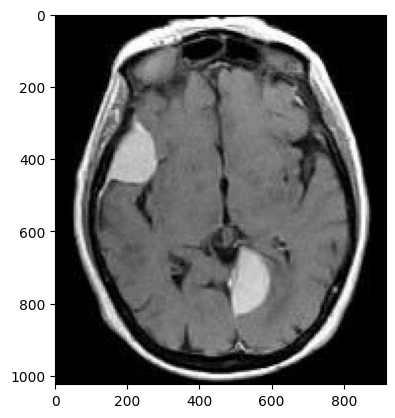

In [20]:
#meningioma tumor
img = io.imread('/content/Multiple-meningiomas-1.jpg')
plt.imshow(img)

In [21]:
import cv2
import numpy as np

# Load the image (replace 'image_path' with your image file's path)
image_path = '/content/Multiple-meningiomas-1.jpg'
img = cv2.imread(image_path)

# Resize the image to match the input size expected by the model
target_size = (252, 252)
img = cv2.resize(img, target_size)

# Scale pixel values to [0, 1]
img = img * 1.0 / 255

# Expand dimensions to match the expected input shape of the model
input_image = np.expand_dims(img, axis=0)

# Make predictions
predictions = model.predict(input_image)

# Display the predictions
class_names = ['glioma_tumor','meningioma_tumor', 'no_tumor', 'pituitary_tumor']
max_prob_index = np.argmax(predictions)
max_prob_class = class_names[max_prob_index]
max_prob_value = predictions[0][max_prob_index]

print("Predicted class:", max_prob_class)
print("Probability:", max_prob_value)


1/1 [==============================] - 1s 819ms/step
Predicted class: meningioma_tumor
Probability: 0.99996626


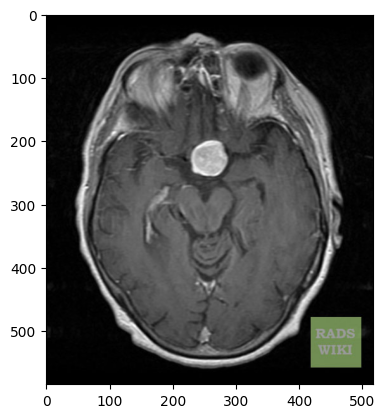

In [23]:
# Pituitary tumor
img2 = io.imread('/content/Pituitary-macroadenoma-MR-T1-axial-post-01.jpg')
plt.imshow(img2)

In [24]:
import cv2
import numpy as np

img2 = cv2.imread('/content/Pituitary-macroadenoma-MR-T1-axial-post-01.jpg')
#resize
img2 = cv2.resize(img2, (252,252))
#rescale
img2 = img2*1./255
#expand dimension
img2 = np.expand_dims(img2, axis=0)

prediction2 = model.predict(img2)

#classes
classes = ['glioma_tumor','meningioma_tumor', 'no_tumor', 'pituitary_tumor']
#max prob index
max_prob_index = np.argmax(prediction2)
max_prob_class = classes[max_prob_index]
max_prob_value = prediction2[0][max_prob_index]

print("Predicted class:", max_prob_class)
print("Probability:", max_prob_value)


1/1 [==============================] - 0s 20ms/step
Predicted class: pituitary_tumor
Probability: 0.9478634
